In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import urllib.request
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from tqdm import tqdm
pylab.rcParams['figure.figsize'] = (8.0, 10.0)


In [2]:
import functools
import os.path
import random
import sys
import xml.etree.ElementTree
import numpy as np
import matplotlib.pyplot as plt
import skimage.data
import cv2
import PIL.Image

In [3]:
import os
import random
from argparse import ArgumentParser
from PIL import Image

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils

from model.networks import Generator
from utils.tools import get_config, random_bbox, mask_image, is_image_file, default_loader, normalize, get_model_list

SEED = 42 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


parser = ArgumentParser()
parser.add_argument('--config', type=str, default='configs/config.yaml',
                    help="training configuration")
parser.add_argument('--seed', type=int, help='manual seed')
parser.add_argument('--image', type=str)
parser.add_argument('--mask', type=str, default='')
parser.add_argument('--output', type=str, default='output.png')
parser.add_argument('--flow', type=str, default='')
parser.add_argument('--checkpoint_path', type=str, default='')
parser.add_argument('--iter', type=int, default=0)

python test_single.py \
	--image examples/imagenet/imagenet_patches_ILSVRC2012_val_00008210_input.png \
	--mask examples/center_mask_256.png \
	--output examples/output.png

# COCO Dataset

In [4]:
dataDir='datasets/coco'
dataType='val2017'
annFile_full='{}/annotations/instances_{}.json'.format(dataDir,dataType)
annFile_human_pose = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)

In [5]:
import torch
import math
irange = range


def make_grid(tensor, nrow=8, padding=2,
              normalize=False, range=None, scale_each=False, pad_value=0):
    """Make a grid of images.

    Args:
        tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
            or a list of images all of the same size.
        nrow (int, optional): Number of images displayed in each row of the grid.
            The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
        padding (int, optional): amount of padding. Default: ``2``.
        normalize (bool, optional): If True, shift the image to the range (0, 1),
            by the min and max values specified by :attr:`range`. Default: ``False``.
        range (tuple, optional): tuple (min, max) where min and max are numbers,
            then these numbers are used to normalize the image. By default, min and max
            are computed from the tensor.
        scale_each (bool, optional): If ``True``, scale each image in the batch of
            images separately rather than the (min, max) over all images. Default: ``False``.
        pad_value (float, optional): Value for the padded pixels. Default: ``0``.

    Example:
        See this notebook `here <https://gist.github.com/anonymous/bf16430f7750c023141c562f3e9f2a91>`_

    """
    if not (torch.is_tensor(tensor) or
            (isinstance(tensor, list) and all(torch.is_tensor(t) for t in tensor))):
        raise TypeError('tensor or list of tensors expected, got {}'.format(type(tensor)))

    # if list of tensors, convert to a 4D mini-batch Tensor
    if isinstance(tensor, list):
        tensor = torch.stack(tensor, dim=0)

    if tensor.dim() == 2:  # single image H x W
        tensor = tensor.unsqueeze(0)
    if tensor.dim() == 3:  # single image
        if tensor.size(0) == 1:  # if single-channel, convert to 3-channel
            tensor = torch.cat((tensor, tensor, tensor), 0)
        tensor = tensor.unsqueeze(0)

    if tensor.dim() == 4 and tensor.size(1) == 1:  # single-channel images
        tensor = torch.cat((tensor, tensor, tensor), 1)

    if normalize is True:
        tensor = tensor.clone()  # avoid modifying tensor in-place
        if range is not None:
            assert isinstance(range, tuple), \
                "range has to be a tuple (min, max) if specified. min and max are numbers"

        def norm_ip(img, min, max):
            img.clamp_(min=min, max=max)
            img.add_(-min).div_(max - min + 1e-5)

        def norm_range(t, range):
            if range is not None:
                norm_ip(t, range[0], range[1])
            else:
                norm_ip(t, float(t.min()), float(t.max()))

        if scale_each is True:
            for t in tensor:  # loop over mini-batch dimension
                norm_range(t, range)
        else:
            norm_range(tensor, range)

    if tensor.size(0) == 1:
        return tensor.squeeze(0)

    # make the mini-batch of images into a grid
    nmaps = tensor.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.size(2) + padding), int(tensor.size(3) + padding)
    grid = tensor.new_full((3, height * ymaps + padding, width * xmaps + padding), pad_value)
    k = 0
    for y in irange(ymaps):
        for x in irange(xmaps):
            if k >= nmaps:
                break
            grid.narrow(1, y * height + padding, height - padding)\
                .narrow(2, x * width + padding, width - padding)\
                .copy_(tensor[k])
            k = k + 1
    return grid



def from_torch_img_to_numpy(tensor, filename, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0):
    """Save a given Tensor into an image file.

    Args:
        tensor (Tensor or list): Image to be saved. If given a mini-batch tensor,
            saves the tensor as a grid of images by calling ``make_grid``.
        **kwargs: Other arguments are documented in ``make_grid``.
    """
    from PIL import Image
    grid = make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    return grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    

In [6]:

config = get_config('configs/config.yaml')

# CUDA configuration
cuda = config['cuda']
print(' ------------- cuda -------------')
print(cuda)
device_ids = config['gpu_ids']
if cuda:
    os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in device_ids)
    device_ids = list(range(len(device_ids)))
    config['gpu_ids'] = device_ids
    cudnn.benchmark = True

# Set random seed
#if args.seed is None:
#    args.seed = SEED#random.randint(1, 10000)
#print("Random seed: {}".format(args.seed))
#random.seed(args.seed)
#torch.manual_seed(args.seed)
#if cuda:
#    torch.cuda.manual_seed_all(args.seed)

print("Configuration: {}".format(config))

def generate(img, img_mask_path, config, model_path):
    with torch.no_grad():   # enter no grad context
        if img_mask_path and is_image_file(img_mask_path):
            # Test a single masked image with a given mask
            x = Image.fromarray(img)
            mask = default_loader(img_mask_path)
            x = transforms.Resize(config['image_shape'][:-1])(x)
            x = transforms.CenterCrop(config['image_shape'][:-1])(x)
            mask = transforms.Resize(config['image_shape'][:-1])(mask)
            mask = transforms.CenterCrop(config['image_shape'][:-1])(mask)
            x = transforms.ToTensor()(x)
            mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0)
            x = normalize(x)
            x = x * (1. - mask)
            x = x.unsqueeze(dim=0)
            mask = mask.unsqueeze(dim=0)
        elif img_mask_path:
            raise TypeError("{} is not an image file.".format(img_mask_path))
        else:
            # Test a single ground-truth image with a random mask
            #ground_truth = default_loader(img_path)
            ground_truth = img
            ground_truth = transforms.Resize(config['image_shape'][:-1])(ground_truth)
            ground_truth = transforms.CenterCrop(config['image_shape'][:-1])(ground_truth)
            ground_truth = transforms.ToTensor()(ground_truth)
            ground_truth = normalize(ground_truth)
            ground_truth = ground_truth.unsqueeze(dim=0)
            bboxes = random_bbox(config, batch_size=ground_truth.size(0))
            x, mask = mask_image(ground_truth, bboxes, config)

        # Set checkpoint path
        if not model_path:
            checkpoint_path = os.path.join('checkpoints',
                                           config['dataset_name'],
                                           config['mask_type'] + '_' + config['expname'])
        else:
            checkpoint_path = model_path

        # Define the trainer
        netG = Generator(config['netG'], cuda, device_ids)
        # Resume weight
        last_model_name = get_model_list(checkpoint_path, "gen", iteration=0)
        
        if cuda:
            netG.load_state_dict(torch.load(last_model_name))
        else:
            netG.load_state_dict(torch.load(last_model_name, map_location='cpu'))
                                 
        model_iteration = int(last_model_name[-11:-3])
        print("Resume from {} at iteration {}".format(checkpoint_path, model_iteration))

        if cuda:
            netG = nn.parallel.DataParallel(netG, device_ids=device_ids)
            x = x.cuda()
            mask = mask.cuda()

        # Inference
        x1, x2, offset_flow = netG(x, mask)
        inpainted_result = x2 * mask + x * (1. - mask)
        inpainted_result =  from_torch_img_to_numpy(inpainted_result, 'output.png', padding=0, normalize=True)

        return inpainted_result
    
def show_img(arr, img_name):
    print(f' --------- inside {img_name} ---------')
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(arr)
    plt.show()
    

 ------------- cuda -------------
False
Configuration: {'dataset_name': 'imagenet', 'data_with_subfolder': True, 'train_data_path': '/media/ouc/4T_B/DuAngAng/datasets/ImageNet/ILSVRC2012_img_train/', 'val_data_path': None, 'resume': None, 'batch_size': 48, 'image_shape': [256, 256, 3], 'mask_shape': [128, 128], 'mask_batch_same': True, 'max_delta_shape': [32, 32], 'margin': [0, 0], 'discounted_mask': True, 'spatial_discounting_gamma': 0.9, 'random_crop': True, 'mask_type': 'hole', 'mosaic_unit_size': 12, 'expname': 'benchmark', 'cuda': False, 'gpu_ids': [0, 1, 2], 'num_workers': 4, 'lr': 0.0001, 'beta1': 0.5, 'beta2': 0.9, 'n_critic': 5, 'niter': 500000, 'print_iter': 100, 'viz_iter': 1000, 'viz_max_out': 16, 'snapshot_save_iter': 5000, 'coarse_l1_alpha': 1.2, 'l1_loss_alpha': 1.2, 'ae_loss_alpha': 1.2, 'global_wgan_loss_alpha': 1.0, 'gan_loss_alpha': 0.001, 'wgan_gp_lambda': 10, 'netG': {'input_dim': 3, 'ngf': 32}, 'netD': {'input_dim': 3, 'ndf': 64}}


/Users/4romain/pCloud Drive/gan_inpainting_for_pose_estimation/utils/tools.py:476: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(stream)


In [7]:
def load_occluders(pascal_voc_root_path):
    occluders = []
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
    
    annotation_paths = list_filepaths(os.path.join(pascal_voc_root_path, 'Annotations'))
    for annotation_path in tqdm(annotation_paths):
        xml_root = xml.etree.ElementTree.parse(annotation_path).getroot()
        
        is_segmented = (xml_root.find('segmented').text != '0')
        
        if not is_segmented:
            continue
        
        
        boxes = []
        for i_obj, obj in enumerate(xml_root.findall('object')):
            is_person = (obj.find('name').text == 'person')
            is_difficult = (obj.find('difficult').text != '0')
            is_truncated = (obj.find('truncated').text != '0')
            if not is_person and not is_difficult and not is_truncated:
                bndbox = obj.find('bndbox')
                box = [int(bndbox.find(s).text) for s in ['xmin', 'ymin', 'xmax', 'ymax']]
                boxes.append((i_obj, box))

        if not boxes:
            continue

        im_filename = xml_root.find('filename').text
        seg_filename = im_filename.replace('jpg', 'png')

        im_path = os.path.join(pascal_voc_root_path, 'JPEGImages', im_filename)
        seg_path = os.path.join(pascal_voc_root_path,'SegmentationObject', seg_filename)

        im = np.asarray(PIL.Image.open(im_path))
        labels = np.asarray(PIL.Image.open(seg_path))

        for i_obj, (xmin, ymin, xmax, ymax) in boxes:
            object_mask = (labels[ymin:ymax, xmin:xmax] == i_obj + 1).astype(np.uint8)*255
            object_image = im[ymin:ymax, xmin:xmax]
            if cv2.countNonZero(object_mask) < 500:
                # Ignore small objects
                continue

            # Reduce the opacity of the mask along the border for smoother blending
            eraoded = cv2.erode(object_mask, structuring_element)
            object_mask[eroded < object_mask] = 192
            object_with_mask = np.concatenate([object_image, object_mask[..., np.newaxis]], axis=-1)
            
            # Downscale for efficiency
            object_with_mask = resize_by_factor(object_with_mask, 0.5)
            occluders.append(object_with_mask)

    return occluders


def occlude_with_objects(im, occluders):
    """Returns an augmented version of `im`, containing some occluders from the Pascal VOC dataset."""

    result = im.copy()
    width_height = np.asarray([im.shape[1], im.shape[0]])
    occluder = occluders[8]
    
    im_scale_factor = min(width_height) / 256
    random_scale_factor = np.random.uniform(0.8, 1)
    scale_factor = random_scale_factor * im_scale_factor #* 1.2
    occluder = resize_by_factor(occluder, scale_factor)
    center = np.random.uniform([0+occluder.shape[0]/2,0+occluder.shape[1]/2], width_height -[occluder.shape[0]/2, occluder.shape[1]/2])
    start_pt, end_pt = paste_over(im_src=occluder, im_dst=result, center=center)
    
    return result, start_pt, end_pt, center


def paste_over(im_src, im_dst, center):
    """Pastes `im_src` onto `im_dst` at a specified position, with alpha blending, in place.

    Locations outside the bounds of `im_dst` are handled as expected (only a part or none of
    `im_src` becomes visible).

    Args:
        im_src: The RGBA image to be pasted onto `im_dst`. Its size can be arbitrary.
        im_dst: The target image.
        alpha: A float (0.0-1.0) array of the same size as `im_src` controlling the alpha blending
            at each pixel. Large values mean more visibility for `im_src`.
        center: coordinates in `im_dst` where the center of `im_src` should be placed.
    """

    width_height_src = np.asarray([im_src.shape[1], im_src.shape[0]])
    width_height_dst = np.asarray([im_dst.shape[1], im_dst.shape[0]])
    
    center = np.round(center).astype(np.int32)
    raw_start_dst = center - width_height_src // 2
    raw_end_dst = raw_start_dst + width_height_src

    start_dst = np.clip(raw_start_dst, 0, width_height_dst)
    end_dst = np.clip(raw_end_dst, 0, width_height_dst)
    region_dst = im_dst[start_dst[1]:end_dst[1], start_dst[0]:end_dst[0]]

    start_src = start_dst - raw_start_dst
    end_src = width_height_src + (end_dst - raw_end_dst)
    region_src = im_src[start_src[1]:end_src[1], start_src[0]:end_src[0]]
    color_src = region_src[..., 0:3]
    alpha = region_src[..., 3:].astype(np.float32)/255
    im_dst[start_dst[1]:end_dst[1], start_dst[0]:end_dst[0]] = (
            alpha * color_src + (1 - alpha) * region_dst)
    return start_dst, end_dst


def resize_by_factor(im, factor):
    """Returns a copy of `im` resized by `factor`, using bilinear interp for up and area interp
    for downscaling.
    """
    new_size = tuple(np.round(np.array([im.shape[1], im.shape[0]]) * factor).astype(int))
    interp = cv2.INTER_LINEAR if factor > 1.0 else cv2.INTER_AREA
    return cv2.resize(im, new_size, fx=factor, fy=factor, interpolation=interp)


def list_filepaths(dirpath):
    names = os.listdir(dirpath)
    paths = [os.path.join(dirpath, name) for name in names]
    return sorted(filter(os.path.isfile, paths))


def show_img(arr):
    print(' --------- occlusion ---------')
    plt.figure(figsize=(10,10))
    plt.imshow(arr)
    plt.show()
    
def show_gray_im(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [8]:
def inspect_data_set(dataDir, dataType, annFile_full, annFile_human_pose, occluders):
    ''' Get the data '''
    # initialize COCO api for instance annotations
    coco=COCO(annFile_full)
    coco_kps=COCO(annFile_human_pose)

    # get all images containing given categories, select one at random
    catIds = coco.getCatIds(catNms=['person'])
    imgIds = coco.getImgIds(catIds=catIds)

    for img_id in imgIds:
        # Get img from id
        img = coco.loadImgs(img_id)[0]

        annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=0)

        if len(annIds) != 1:
            continue
    
        anns = coco_kps.loadAnns(annIds)
        if anns[0]['area'] < 3000:
            continue
    
        if anns[0]['num_keypoints'] < 10:
            continue
    
        arr = io.imread(img['coco_url'])
        show_img_and_anno_from_array(arr, anns, coco_kps)

        # Slice Bounding Box
        bbox = anns[0]['bbox']
        bbox = list(map(int, bbox))
        bbox_arr = arr[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]

        occluded_im, start_pt, end_pt, center = occlude_with_objects(bbox_arr, occluders)

        # Crop the img where an occlusion appears
        x_y_occ_mask = [end_pt[0]-start_pt[0], end_pt[1]-start_pt[1]]
        center_arr = np.round(center).astype(np.int32)
        c_main_img =[center_arr[0]+bbox[0], center_arr[1]+bbox[1]]
        alpha = 5
        x_y_mask = [c_main_img[1] - x_y_occ_mask[1] - alpha, c_main_img[0] - x_y_occ_mask[0]- alpha]

        arr[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :] = occluded_im
        show_gray_im(arr)
        #show_img_and_anno_from_array(arr, anns, coco_kps)

        print(' --------------------------- CRROOOOOOOP ---------------------------')
        max_crop_side = max(x_y_occ_mask)
        img_for_generation = arr[x_y_mask[0]:x_y_mask[0]+max_crop_side*2 + alpha, x_y_mask[1]:x_y_mask[1]+max_crop_side*2 + alpha, :]
        
        print(img_for_generation.shape)
        if (img_for_generation.shape[0] == 0) or (img_for_generation.shape[1] == 0):
            print(' --------------------------- CONTINUE --------------------------- ')
            continue
        
        gen_img = generate(img_for_generation, 'generative-inpainting-pytorch/examples/center_mask_256.png', config, '')
        final_gen_img = cv2.resize(gen_img, (img_for_generation.shape[1],img_for_generation.shape[0]))
        arr[x_y_mask[0]:x_y_mask[0]+max_crop_side*2 + alpha, x_y_mask[1]:x_y_mask[1]+max_crop_side*2 + alpha, :] = final_gen_img
        show_gray_im(arr)
        
        print(img['id'])
    
        #arr[x_y_mask[0]:x_y_mask[0]+x_y_occ_mask[0]*2 + alpha, x_y_mask[1]:x_y_mask[1]+x_y_occ_mask[1]*2 + alpha, :] = 0
        #show_gray_im(arr)
        ##show_img_and_anno_from_array(arr, anns, coco_kps)


def show_img_and_anno(img, anns, coco_kps):
    plt.figure(figsize=(10,10))    
    print(' -------------- img object -------------- ')
    # load and display img
    I = io.imread(img['coco_url'])
    #plt.axis('off')
    plt.imshow(I)
    # load and display keypoints annotations
    #plt.imshow(I)
    plt.axis('off')
    ax = plt.gca()
    coco_kps.showAnns(anns)
    plt.show()

def show_img_and_anno_from_array(arr, anns, coco_kps):
    plt.figure(figsize=(10,10))    
    print(' -------------- img object -------------- ')
    # load and display img
    plt.imshow(arr)
    # load and display keypoints annotations
    #plt.imshow(I)
    plt.axis('off')
    ax = plt.gca()
    coco_kps.showAnns(anns)
    plt.show()
    
def show_gray_im(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()

In [9]:
#occluders = load_occluders('synthetic-occlusion/VOCdevkit/VOC2012')
import pickle

#with open('pre_process_folder/occluders.pkl', 'wb') as f:
#    pickle.dump(occluders, f)
    
with open('pre_process_folder/occluders.pkl', 'rb') as f:
    occluders = pickle.load(f)

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
 -------------- img object -------------- 


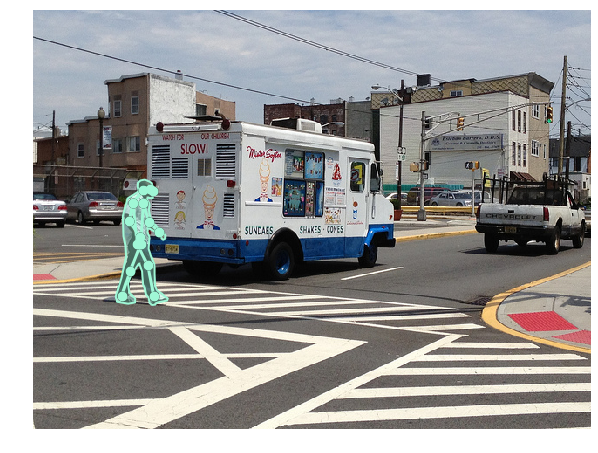

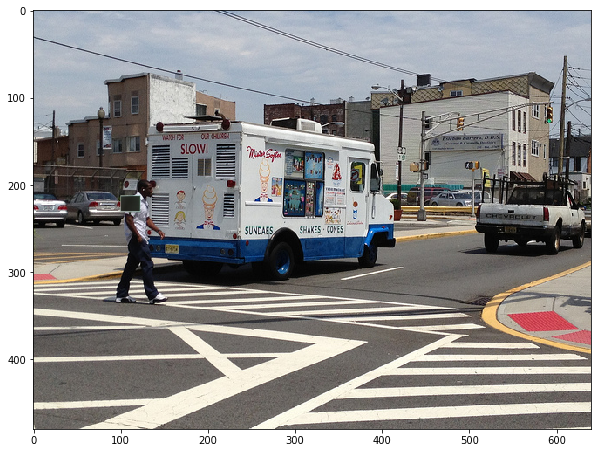

 --------------------------- CRROOOOOOOP ---------------------------
(55, 55, 3)
------------- checkpoints/imagenet/hole_benchmark -------------
------------- gen -------------
Resume from checkpoints/imagenet/hole_benchmark at iteration 430000


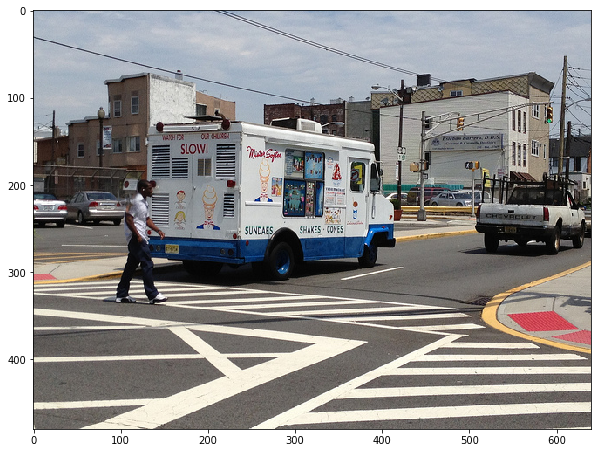

393226
 -------------- img object -------------- 


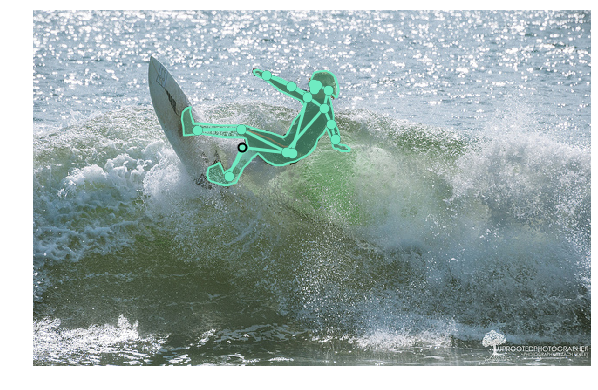

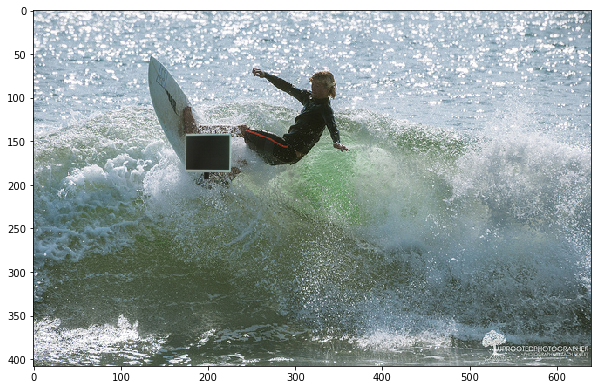

 --------------------------- CRROOOOOOOP ---------------------------
(121, 121, 3)
------------- checkpoints/imagenet/hole_benchmark -------------
------------- gen -------------
Resume from checkpoints/imagenet/hole_benchmark at iteration 430000


KeyboardInterrupt: 

In [10]:
inspect_data_set(dataDir, dataType, annFile_full, annFile_human_pose, occluders)